# 🎉 Out-of-Distribution (OOD) with PCA using Deep Features from the Latent Space

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks using deep features from the latent space

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [84]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [85]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from images_standardizing import *

In [86]:
import tarfile

def extract_tgz(tgz_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
        print(f"Arquivos extraídos para {extract_to}")

tgz_path = '../CBIR_15-Scene.tgz'
extract_to = '../data/'

extract_tgz(tgz_path, extract_to)

Arquivos extraídos para ../data/


In [87]:
df = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
4480,../data/CBIR_15-Scene/14/4481.jpg,Store
4481,../data/CBIR_15-Scene/14/4482.jpg,Store
4482,../data/CBIR_15-Scene/14/4483.jpg,Store
4483,../data/CBIR_15-Scene/14/4484.jpg,Store


## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [88]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
1267,../data/CBIR_15-Scene/05/1268.jpg,Coast
1268,../data/CBIR_15-Scene/05/1269.jpg,Coast
1269,../data/CBIR_15-Scene/05/1270.jpg,Coast
1270,../data/CBIR_15-Scene/05/1271.jpg,Coast
1271,../data/CBIR_15-Scene/05/1272.jpg,Coast
...,...,...
4165,../data/CBIR_15-Scene/13/4166.jpg,Office
4166,../data/CBIR_15-Scene/13/4167.jpg,Office
4167,../data/CBIR_15-Scene/13/4168.jpg,Office
4168,../data/CBIR_15-Scene/13/4169.jpg,Office


It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [89]:
X = df_different['image_path'].tolist()
y = df_different['category'].tolist()
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Coast', 'Office']


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [90]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

Now, we should load our patches for training:

In [91]:
#training_images_by_category = load_images_by_category('images_train', y, image_size=(224, 224))
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))
print(training_images_by_category)

{'Coast': array([[[[105, 105, 105],
         [105, 105, 105],
         [110, 110, 110],
         ...,
         [ 69,  69,  69],
         [ 70,  70,  70],
         [ 70,  70,  70]],

        [[ 95,  95,  95],
         [ 98,  98,  98],
         [105, 105, 105],
         ...,
         [ 67,  67,  67],
         [ 68,  68,  68],
         [ 67,  67,  67]],

        [[ 96,  96,  96],
         [ 96,  96,  96],
         [ 98,  98,  98],
         ...,
         [ 67,  67,  67],
         [ 67,  67,  67],
         [ 66,  66,  66]],

        ...,

        [[ 17,  17,  17],
         [ 16,  16,  16],
         [ 18,  18,  18],
         ...,
         [ 48,  48,  48],
         [ 46,  46,  46],
         [ 44,  44,  44]],

        [[ 40,  40,  40],
         [ 33,  33,  33],
         [ 25,  25,  25],
         ...,
         [ 51,  51,  51],
         [ 50,  50,  50],
         [ 49,  49,  49]],

        [[ 45,  45,  45],
         [ 47,  47,  47],
         [ 42,  42,  42],
         ...,
         [ 53,  53,  53]

In [92]:
from sklearn.preprocessing import StandardScaler

def normalize_and_center_images(images, scaler=None):
    # Flatten the images array for scaling
    num_images, height, width, channels = images.shape
    flattened_images = images.reshape((num_images, -1))
    
    if scaler is None:
        scaler = StandardScaler()
        standardized_flattened_images = scaler.fit_transform(flattened_images)
    else:
        standardized_flattened_images = scaler.transform(flattened_images)
    
    # Reshape back to the original shape
    standardized_images = standardized_flattened_images.reshape((num_images, height, width, channels))
    return standardized_images, scaler

standardized_images_by_category = {}
scalers_by_category = {}
for category, images in training_images_by_category.items():
    print(images.shape)
    standardized_images, scaler = normalize_and_center_images(images)
    standardized_images_by_category[category] = standardized_images
    scalers_by_category[category] = scaler
    print(f"Category {category}, images shape: {standardized_images.shape}")


(348, 224, 224, 3)
Category Coast, images shape: (348, 224, 224, 3)
(209, 224, 224, 3)
Category Office, images shape: (209, 224, 224, 3)


### 🏋🏽‍♂️ Training phase

Now that the have our training patches stored in that variable above, we should start our analysis with PCA.

First of all, we **need to normalize and center** the data. It's so importantt that I had to emphasize it. Plus, since we are dealing with different categories, each one of them should be normalized with a different scaler (and we're going to save it for later).

In [93]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [94]:
preprocessed_images_by_category = {}
input_size = (224, 224)
for category, images in training_images_by_category.items():
    resized_images = np.array([resize_image(patch, input_size) for patch in images])
    preprocessed_images = preprocess_input(resized_images)
    preprocessed_images_by_category[category] = preprocessed_images

for category, images in preprocessed_images_by_category.items():
    print(f"Category {category}, images shape: {images.shape}")

Category Coast, images shape: (348, 224, 224, 3)
Category Office, images shape: (209, 224, 224, 3)


In [95]:
preprocessed_images_by_category = standardized_images_by_category 

base_model = VGG16(weights='imagenet', include_top=True)
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [96]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [97]:
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    features = model.predict(images)
    features_by_category[category] = features

for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")

7/7 [==============================] - 16s 2s/step
Category Coast, features shape: (348, 4096)
Category Office, features shape: (209, 4096)


In [98]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Category Coast, principal components: 66
Category Office, principal components: 73
Category Coast, principal components shape: (66, 4096)
Category Coast, explained variance: 95.08%
Category Office, principal components shape: (73, 4096)
Category Office, explained variance: 95.00%


### Testing phase


In [99]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_standardized_images_by_category = {}
    test_scalers_by_category = {}

    for category, images in test_images_by_category.items():
        test_standardized_images, test_scaler = normalize_and_center_images(images)
        test_standardized_images_by_category[category] = test_standardized_images
        test_scalers_by_category[category] = test_scaler

    return test_standardized_images_by_category

image_size = (224, 224)

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size)


In [100]:
def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


3/3 [==============================] - 5s 1s/step


In [101]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Coast
Category Coast, mean reconstruction error: 0.002847319934517145
Category Office, mean reconstruction error: 0.014802556484937668
Best category: Coast
Test category: Office
Category Coast, mean reconstruction error: 0.020261263474822044
Category Office, mean reconstruction error: 0.005833134986460209
Best category: Office


## Agnostic Spaces Analsys

In [102]:
# Get the Principal Components from both categories
# First, we're going to test for "Coast" and "Office"

pca_coast = pca_by_category['Coast']
components_coast = pca_coast.components_
explained_variance_ratio_coast = pca_coast.explained_variance_ratio_


pca_office = pca_by_category['Office']
components_office = pca_office.components_
explained_variance_ratio_office = pca_office.explained_variance_ratio_

print(components_office.shape)
print(components_coast.shape)

(73, 4096)
(66, 4096)


In [103]:
norms_of_means_coast = []

for component in components_coast:
    dot_products = np.dot(components_office, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_coast.append(norm_of_mean)

norms_of_means_coast = np.array(norms_of_means_coast)

norms_of_means_office = []

for component in components_office:
    dot_products = np.dot(components_coast, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_office.append(norm_of_mean)

norms_of_means_office = np.array(norms_of_means_office)

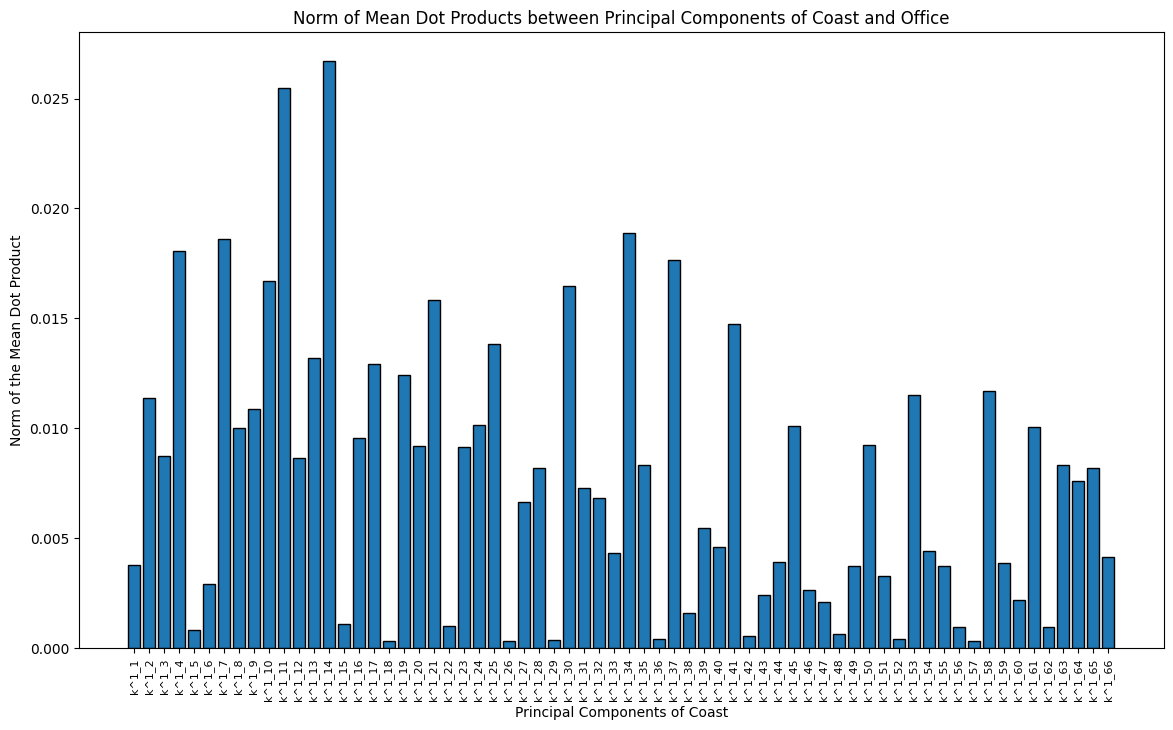

In [104]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_coast))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_coast, edgecolor='black')
plt.xlabel('Principal Components of Coast')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Coast and Office')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


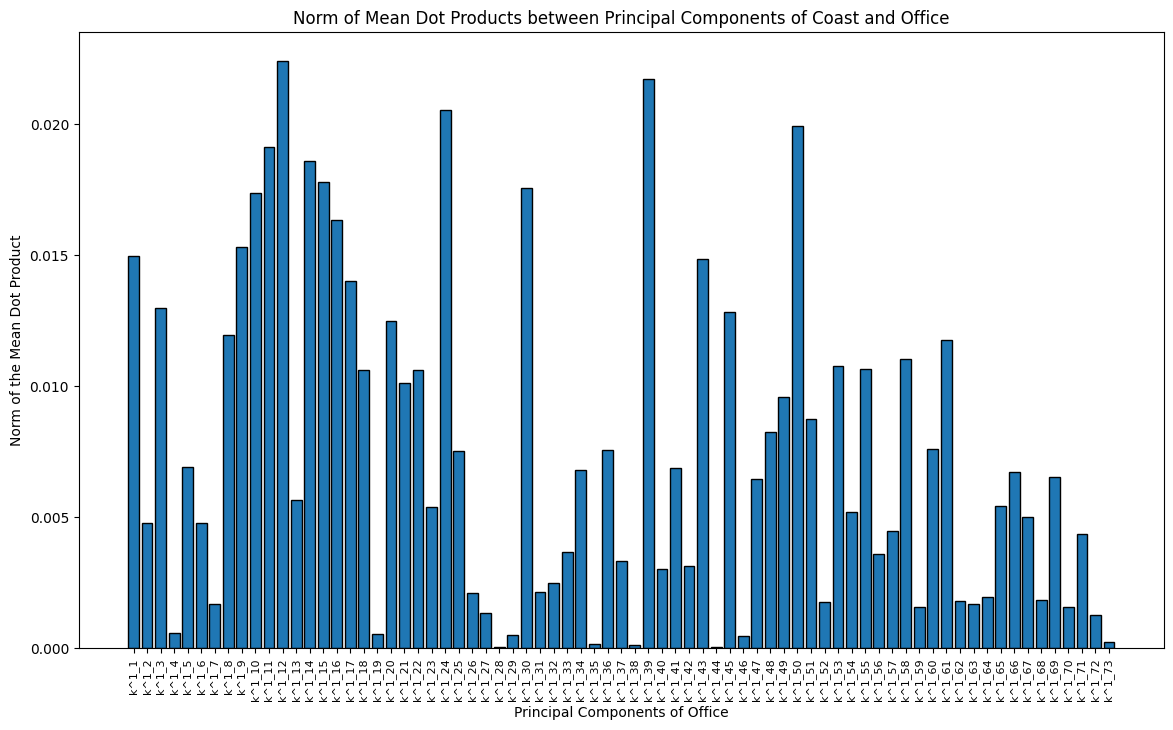

In [105]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_office))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_office, edgecolor='black')
plt.xlabel('Principal Components of Office')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Coast and Office')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


In [106]:
threshold_percentile = 10

threshold_value_coast = np.percentile(norms_of_means_coast, threshold_percentile)
threshold_value_office = np.percentile(norms_of_means_office, threshold_percentile)

# Get the indices with the smallest values
specific_indices_coast = np.where(norms_of_means_coast <= threshold_value_coast)[0]
specific_indices_office = np.where(norms_of_means_office <= threshold_value_office)[0]

print("Specific Indices for Coast:", specific_indices_coast + 1)
print("Specific Indices for Office:", specific_indices_office + 1)

Specific Indices for Coast: [18 26 29 36 42 52 57]
Specific Indices for Office: [19 28 29 35 38 44 46 73]


In [107]:
test_coast_features = test_features_by_category['Coast']
test_office_features = test_features_by_category['Office']

print(test_coast_features.shape)
print(test_office_features.shape)

(140, 4096)
(72, 4096)


In [108]:
specific_components_coast = pca_coast.components_[specific_indices_coast]
specific_components_office = pca_office.components_[specific_indices_office]

for i, index in enumerate(specific_indices_coast):
    print(f"Component {index + 1}: {np.array_equal(components_coast[index], specific_components_coast[i])}")

print("==================")

for i, index in enumerate(specific_indices_office):
    print(f"Component {index + 1}: {np.array_equal(components_office[index], specific_components_office[i])}")


Component 18: True
Component 26: True
Component 29: True
Component 36: True
Component 42: True
Component 52: True
Component 57: True
Component 19: True
Component 28: True
Component 29: True
Component 35: True
Component 38: True
Component 44: True
Component 46: True
Component 73: True


In [109]:
def project_and_reconstruct(original_features, specific_components):
    # Flatten the original features
    flattened_features = np.array([feature.flatten() for feature in original_features])
    
    # Project the data into the specific components
    projected_features = np.dot(flattened_features, specific_components.T)
    
    # Reconstruct the features
    reconstructed_features = np.dot(projected_features, specific_components)
    
    # Reshape the reconstructed features into the original shape
    reconstructed_features = reconstructed_features.reshape(original_features.shape)
    
    return reconstructed_features

reconstructed_test_coast_coast_images = project_and_reconstruct(test_coast_features, specific_components_coast)
reconstructed_test_coast_office_images = project_and_reconstruct(test_coast_features, specific_components_office)

print("Reconstructed Test Coast Images (using Coast components):", reconstructed_test_coast_coast_images)
print("Reconstructed Test Coast Images (using Coast components):", reconstructed_test_coast_coast_images.shape)
print("Reconstructed Test Coast Images (using Office components):", reconstructed_test_coast_office_images)
print("Reconstructed Test Coast Images (using Office components):", reconstructed_test_coast_office_images.shape)

reconstructed_test_office_coast_images = project_and_reconstruct(test_office_features, specific_components_coast)
reconstructed_test_office_office_images = project_and_reconstruct(test_office_features, specific_components_office)

print("Reconstructed Test Office Images (using Coast components):", reconstructed_test_office_coast_images)
print("Reconstructed Test Office Images (using Coast components):", reconstructed_test_office_coast_images.shape)
print("Reconstructed Test Office Images (using Office components):", reconstructed_test_office_office_images)
print("Reconstructed Test Office Images (using Office components):", reconstructed_test_office_office_images.shape)


Reconstructed Test Coast Images (using Coast components): [[ 6.9276275e-08 -3.0237556e-01  2.2120324e-01 ...  0.0000000e+00
  -5.1747374e-02  1.6684182e-01]
 [ 1.5894325e-07 -2.4783841e-01  1.8780299e-01 ...  0.0000000e+00
  -4.7713730e-02  1.5001990e-01]
 [ 4.8543040e-08 -2.8492880e-01  2.2297201e-01 ...  0.0000000e+00
  -4.9621329e-02  2.3375952e-01]
 ...
 [ 1.6749105e-07 -2.6125830e-01  2.1129906e-01 ...  0.0000000e+00
  -5.0194908e-02  1.7017654e-01]
 [ 2.3628388e-07 -2.5714543e-01  2.2389378e-01 ...  0.0000000e+00
  -3.1720586e-02  1.4820038e-01]
 [ 1.4204500e-07 -2.9490510e-01  2.1882486e-01 ...  0.0000000e+00
  -5.2741561e-02  1.9202320e-01]]
Reconstructed Test Coast Images (using Coast components): (140, 4096)
Reconstructed Test Coast Images (using Office components): [[-0.05356968  0.2897725   0.02446982 ...  0.          0.
  -0.08436564]
 [-0.03818374  0.27465937  0.05262481 ...  0.          0.
  -0.06544475]
 [-0.07091084  0.25146416  0.03635443 ...  0.          0.
  -0.0540

In [110]:
residuals_coast_coast = test_coast_features - reconstructed_test_coast_coast_images
residuals_coast_office = test_coast_features - reconstructed_test_coast_office_images

residuals_office_coast = test_office_features - reconstructed_test_office_office_images
residuals_office_office = test_office_features - reconstructed_test_office_office_images

# Print residuals
print("Residuals Coast-Coast:", residuals_coast_coast)
print("Residuals Coast-Office:", residuals_coast_office)
print("Residuals Office-Coast:", residuals_office_coast)
print("Residuals Office-Office:", residuals_office_office)

Residuals Coast-Coast: [[-6.9276275e-08  3.0237556e-01  9.3539560e-01 ...  0.0000000e+00
   5.1747374e-02  3.5034865e-01]
 [-1.5894325e-07  3.1542322e-01  1.2478015e+00 ...  0.0000000e+00
   4.7713730e-02  4.1132665e-01]
 [-4.8543040e-08  2.8492880e-01  1.0204723e+00 ...  0.0000000e+00
   4.9621329e-02  2.8221661e-01]
 ...
 [-1.6749105e-07  2.7534470e-01  1.2733077e+00 ...  0.0000000e+00
   5.0194908e-02  2.9609159e-01]
 [-2.3628388e-07  2.5714543e-01  1.3703697e+00 ...  0.0000000e+00
   3.1720586e-02  4.7848737e-01]
 [-1.4204500e-07  2.9490510e-01  1.3072398e+00 ...  0.0000000e+00
   5.2741561e-02  3.7171483e-01]]
Residuals Coast-Office: [[ 0.05356968 -0.2897725   1.132129   ...  0.          0.
   0.60155606]
 [ 0.03818374 -0.20707455  1.3829798  ...  0.          0.
   0.6267913 ]
 [ 0.07091084 -0.25146416  1.2070899  ...  0.          0.
   0.5700693 ]
 ...
 [ 0.04851428 -0.30453578  1.3835323  ...  0.          0.
   0.5019906 ]
 [ 0.07678115 -0.24796057  1.5877403  ...  0.          0

In [111]:
def calculate_ood(original_features, residuals):
    residual_norms = np.linalg.norm(residuals, axis=1)
    original_norms = np.linalg.norm(original_features, axis=1)
    ood_scores = residual_norms / original_norms
    return ood_scores

In [112]:

# Calculate OOD scores
ood_scores_coast_coast = calculate_ood(test_coast_features, residuals_coast_coast)
ood_scores_coast_office = calculate_ood(test_coast_features, residuals_coast_office)

ood_scores_office_coast = calculate_ood(test_office_features, residuals_office_coast)
ood_scores_office_office = calculate_ood(test_office_features, residuals_office_office)

# Print OOD scores
print("OOD Scores Coast-Coast:", ood_scores_coast_coast)
print("OOD Scores Coast-Office:", ood_scores_coast_office)
print("OOD Scores Office-Office:", ood_scores_office_office)
print("OOD Scores Office-Coast:", ood_scores_office_coast)



OOD Scores Coast-Coast: [0.962863   0.9730982  0.9722711  0.9690977  0.9672339  0.96961534
 0.9657837  0.9773838  0.9680307  0.9686873  0.9668911  0.97371477
 0.9680219  0.9705801  0.96688354 0.96780825 0.9787222  0.96885234
 0.96654737 0.9690619  0.9705464  0.9732963  0.9689512  0.9722236
 0.9707643  0.9701527  0.9673232  0.9681956  0.9668393  0.97095335
 0.9711979  0.97171986 0.9727806  0.9723764  0.9714052  0.9694932
 0.96830076 0.9673021  0.9697433  0.9711049  0.9712902  0.9780326
 0.9702522  0.9730095  0.9709416  0.9698809  0.97187954 0.96911526
 0.9693532  0.96739244 0.9702255  0.96958745 0.96920776 0.9703954
 0.9715505  0.9717962  0.96655786 0.9710462  0.97037446 0.97098655
 0.9644193  0.96988267 0.9676352  0.97193813 0.9701353  0.9699211
 0.96923125 0.9709063  0.9717543  0.97223663 0.9722539  0.97092575
 0.97263014 0.9704971  0.9699729  0.96993977 0.9726667  0.96952045
 0.97423285 0.9706853  0.9707658  0.9689924  0.9663943  0.9686142
 0.97010463 0.96577656 0.96885246 0.9672327 

In [113]:
# Aggregate OOD scores
ood_scores_coast = {
    'Coast-Coast': np.mean(ood_scores_coast_coast),
    'Coast-Office': np.mean(ood_scores_coast_office)
}
ood_scores_office = {
    'Office-Office': np.mean(ood_scores_office_office),
    'Office-Coast': np.mean(ood_scores_office_coast)
}

# Determine the best environment for each test set
best_environment_coast = min(ood_scores_coast, key=ood_scores_coast.get)
best_environment_office = min(ood_scores_office, key=ood_scores_office.get)

print(f"OOD scores (COAST TEST): {ood_scores_coast}")
print(f"Best environment (COAST TEST): {best_environment_coast}")

print(f"OOD scores (OFFICE TEST): {ood_scores_office}")
print(f"Best environment (OFFICE TEST): {best_environment_office}")

OOD scores (COAST TEST): {'Coast-Coast': 0.97002304, 'Coast-Office': 0.9800389}
Best environment (COAST TEST): Coast-Coast
OOD scores (OFFICE TEST): {'Office-Office': 0.9762607, 'Office-Coast': 0.9762607}
Best environment (OFFICE TEST): Office-Office


## Mahalanobis Distance Analysis

In [114]:
from scipy.spatial.distance import mahalanobis

def calculate_mahalanobis_distance(features, mean, cov_inv):
    distances = []
    for feature in features:
        distance = mahalanobis(feature, mean, cov_inv)
        distances.append(distance)
    return np.array(distances)

def calculate_mean_cov(features):
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    cov += np.eye(cov.shape[0])
    cov_inv = np.linalg.inv(cov)
    return mean, cov_inv

train_coast_features = features_by_category['Coast']
train_office_features = features_by_category['Office']

mean_coast, cov_inv_coast = calculate_mean_cov(train_coast_features)
mean_office, cov_inv_office = calculate_mean_cov(train_office_features)

mahalanobis_distances_coast_coast = calculate_mahalanobis_distance(test_coast_features, mean_coast, cov_inv_coast)
mahalanobis_distances_coast_office = calculate_mahalanobis_distance(test_coast_features, mean_office, cov_inv_office)

mahalanobis_distances_office_office = calculate_mahalanobis_distance(test_office_features, mean_office, cov_inv_office)
mahalanobis_distances_office_coast = calculate_mahalanobis_distance(test_office_features, mean_coast, cov_inv_coast)


In [115]:
ood_scores_coast_mahalanobis = {
    'Coast-Coast': np.mean(mahalanobis_distances_coast_coast),
    'Coast-Office': np.mean(mahalanobis_distances_coast_office)
}
ood_scores_office_mahalanobis = {
    'Office-Office': np.mean(mahalanobis_distances_office_office),
    'Office-Coast': np.mean(mahalanobis_distances_office_coast)
}

best_environment_coast = min(ood_scores_coast_mahalanobis, key=ood_scores_coast_mahalanobis.get)
best_environment_office = min(ood_scores_office_mahalanobis, key=ood_scores_office_mahalanobis.get)

print(f"OOD scores (COAST TEST) MAHALANOBIS: {ood_scores_coast_mahalanobis}")
print(f"Best environment (COAST TEST): {best_environment_coast}")

print(f"OOD scores (OFFICE TEST) MAHALANOBIS: {ood_scores_office_mahalanobis}")
print(f"Best environment (OFFICE TEST): {best_environment_office}")

OOD scores (COAST TEST) MAHALANOBIS: {'Coast-Coast': 4.072997063427455, 'Coast-Office': 12.729220524582752}
Best environment (COAST TEST): Coast-Coast
OOD scores (OFFICE TEST) MAHALANOBIS: {'Office-Office': 5.388170705540484, 'Office-Coast': 13.868532916635726}
Best environment (OFFICE TEST): Office-Office


## ✌️ Part II: Comparing two similar environments

In [116]:
train_categories = ['Bedroom', 'LivingRoom']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
1262,../data/CBIR_15-Scene/04/1263.jpg,LivingRoom
1263,../data/CBIR_15-Scene/04/1264.jpg,LivingRoom
1264,../data/CBIR_15-Scene/04/1265.jpg,LivingRoom
1265,../data/CBIR_15-Scene/04/1266.jpg,LivingRoom


In [117]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)

image_size = (224, 224)
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")


Unique categories: ['Bedroom', 'LivingRoom']


In [118]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [119]:
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))
print(training_images_by_category)

{'Bedroom': array([[[[218, 218, 218],
         [222, 222, 222],
         [224, 224, 224],
         ...,
         [210, 210, 210],
         [225, 225, 225],
         [225, 225, 225]],

        [[195, 195, 195],
         [198, 198, 198],
         [197, 197, 197],
         ...,
         [235, 235, 235],
         [255, 255, 255],
         [255, 255, 255]],

        [[168, 168, 168],
         [162, 162, 162],
         [168, 168, 168],
         ...,
         [238, 238, 238],
         [255, 255, 255],
         [254, 254, 254]],

        ...,

        [[174, 174, 174],
         [182, 182, 182],
         [183, 183, 183],
         ...,
         [183, 183, 183],
         [185, 185, 185],
         [204, 204, 204]],

        [[192, 192, 192],
         [196, 196, 196],
         [195, 195, 195],
         ...,
         [249, 249, 249],
         [249, 249, 249],
         [252, 252, 252]],

        [[239, 239, 239],
         [248, 248, 248],
         [248, 248, 248],
         ...,
         [254, 254, 25

In [120]:
standardized_images_by_category = {}
scalers_by_category = {}
for category, images in training_images_by_category.items():
    standardized_images, scaler = normalize_and_center_images(images)
    standardized_images_by_category[category] = standardized_images
    scalers_by_category[category] = scaler


In [121]:
preprocessed_images_by_category = {}
for category, images in standardized_images_by_category.items():
    resized_images = np.array([resize_image(image, input_size) for image in images])
    preprocessed_images = preprocess_input(resized_images)
    preprocessed_images_by_category[category] = preprocessed_images

preprocessed_images = standardized_images_by_category

for category, images in preprocessed_images_by_category.items():
    print(f"Categoria {category}, images shape: {images.shape}")

Categoria Bedroom, images shape: (207, 224, 224, 3)
Categoria LivingRoom, images shape: (278, 224, 224, 3)


In [122]:
base_model = VGG16(weights='imagenet', include_top=True)

In [123]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [124]:
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    features = model.predict(images)
    features_by_category[category] = features

for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")

9/9 [==============================] - 19s 2s/step
Category Bedroom, features shape: (207, 4096)
Category LivingRoom, features shape: (278, 4096)


In [125]:
from sklearn.decomposition import PCA

pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Category Bedroom, principal components: 45
Category LivingRoom, principal components: 45
Category Bedroom, principal components shape: (45, 4096)
Category Bedroom, explained variance: 95.09%
Category LivingRoom, principal components shape: (45, 4096)
Category LivingRoom, explained variance: 95.10%


In [126]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_standardized_images_by_category = {}
    test_scalers_by_category = {}

    for category, images in test_images_by_category.items():
        test_standardized_images, test_scaler = normalize_and_center_images(images)
        test_standardized_images_by_category[category] = test_standardized_images
        test_scalers_by_category[category] = test_scaler

    return test_standardized_images_by_category

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size)


In [127]:
def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


4/4 [==============================] - 8s 2s/step


In [128]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        # Calcular o erro de reconstrução
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.08994294703006744
Category LivingRoom, mean reconstruction error: 0.08675361424684525
Best category: LivingRoom
Test category: LivingRoom
Category Bedroom, mean reconstruction error: 0.07954106479883194
Category LivingRoom, mean reconstruction error: 0.07679051905870438
Best category: LivingRoom


## Agnostic Spaces

In [129]:
# Get the Principal Components from both categories
# First, we're going to test for "bedroom" and "livingroom"

pca_bedroom = pca_by_category['Bedroom']
components_bedroom = pca_bedroom.components_
explained_variance_ratio_bedroom = pca_bedroom.explained_variance_ratio_


pca_livingroom = pca_by_category['LivingRoom']
components_livingroom = pca_livingroom.components_
explained_variance_ratio_livingroom = pca_livingroom.explained_variance_ratio_

print(components_livingroom.shape)
print(components_bedroom.shape)

(45, 4096)
(45, 4096)


In [130]:
norms_of_means_bedroom = []

for component in components_bedroom:
    dot_products = np.dot(components_livingroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_bedroom.append(norm_of_mean)

norms_of_means_bedroom = np.array(norms_of_means_bedroom)

norms_of_means_livingroom = []

for component in components_livingroom:
    dot_products = np.dot(components_bedroom, component)
    mean_dot_product = np.mean(dot_products)
    norm_of_mean = np.linalg.norm(mean_dot_product)
    norms_of_means_livingroom.append(norm_of_mean)

norms_of_means_livingroom = np.array(norms_of_means_livingroom)

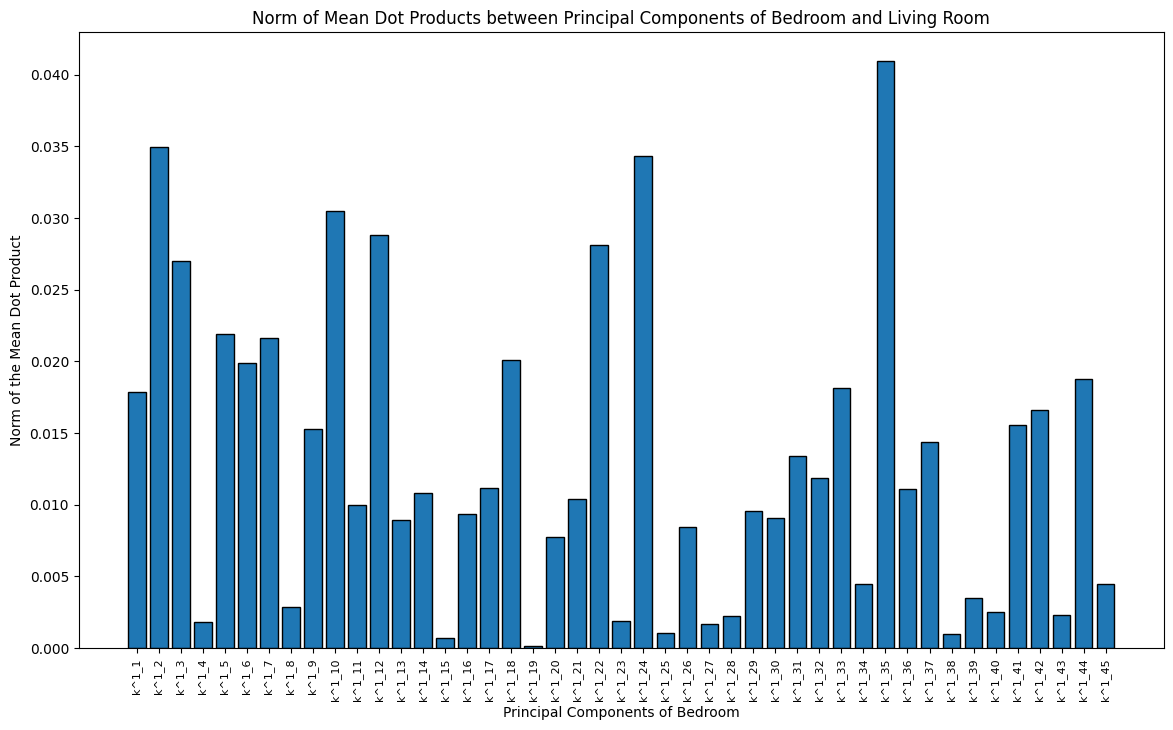

In [131]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_bedroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_bedroom, edgecolor='black')
plt.xlabel('Principal Components of Bedroom')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Bedroom and Living Room')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


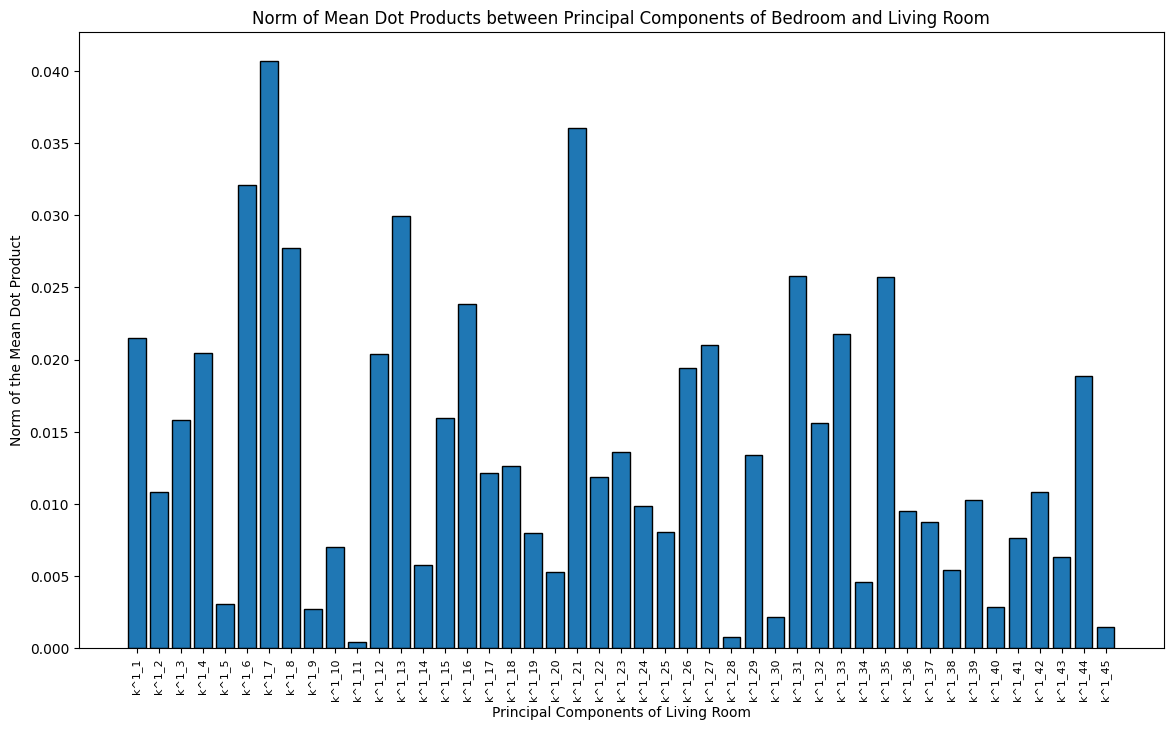

In [132]:
x_labels = [f'k^1_{i+1}' for i in range(len(components_livingroom))]

plt.figure(figsize=(14, 8))  
plt.bar(x_labels, norms_of_means_livingroom, edgecolor='black')
plt.xlabel('Principal Components of Living Room')
plt.ylabel('Norm of the Mean Dot Product')
plt.title('Norm of Mean Dot Products between Principal Components of Bedroom and Living Room')

plt.xticks(rotation=90, fontsize=8)
plt.xticks(range(0, len(x_labels), 1), x_labels[::1])
plt.show()


In [133]:
threshold_percentile = 10

threshold_value_bedroom = np.percentile(norms_of_means_bedroom, threshold_percentile)
threshold_value_livingroom = np.percentile(norms_of_means_livingroom, threshold_percentile)

# Get the indices with the smallest values
specific_indices_bedroom = np.where(norms_of_means_bedroom <= threshold_value_bedroom)[0]
specific_indices_livingroom = np.where(norms_of_means_livingroom <= threshold_value_livingroom)[0]

print("Specific Indices for Bedroom:", specific_indices_bedroom + 1)
print("Specific Indices for Living Room:", specific_indices_livingroom + 1)

Specific Indices for Bedroom: [15 19 25 27 38]
Specific Indices for Living Room: [ 9 11 28 30 45]


In [134]:
test_bedroom_features = test_features_by_category['Bedroom']
test_livingroom_features = test_features_by_category['LivingRoom']

print(test_bedroom_features.shape)
print(test_livingroom_features.shape)

(78, 4096)
(101, 4096)


In [135]:
specific_components_bedroom = pca_bedroom.components_[specific_indices_bedroom]
specific_components_livingroom = pca_livingroom.components_[specific_indices_livingroom]

for i, index in enumerate(specific_indices_bedroom):
    print(f"Component {index + 1}: {np.array_equal(components_bedroom[index], specific_components_bedroom[i])}")

print("==================")

for i, index in enumerate(specific_indices_livingroom):
    print(f"Component {index + 1}: {np.array_equal(components_livingroom[index], specific_components_livingroom[i])}")


Component 15: True
Component 19: True
Component 25: True
Component 27: True
Component 38: True
Component 9: True
Component 11: True
Component 28: True
Component 30: True
Component 45: True


In [136]:
def project_and_reconstruct(original_features, specific_components):
    # Flatten the original features
    flattened_features = np.array([feature.flatten() for feature in original_features])
    
    # Project the data into the specific components
    projected_features = np.dot(flattened_features, specific_components.T)
    
    # Reconstruct the features
    reconstructed_features = np.dot(projected_features, specific_components)
    
    # Reshape the reconstructed features into the original shape
    reconstructed_features = reconstructed_features.reshape(original_features.shape)
    
    return reconstructed_features

reconstructed_test_bedroom_bedroom_images = project_and_reconstruct(test_bedroom_features, specific_components_bedroom)
reconstructed_test_bedroom_livingroom_images = project_and_reconstruct(test_bedroom_features, specific_components_livingroom)

print("Reconstructed Test Bedroom Images (using Bedroom components):", reconstructed_test_bedroom_bedroom_images)
print("Reconstructed Test Bedroom Images (using Bedroom components):", reconstructed_test_bedroom_bedroom_images.shape)
print("Reconstructed Test Bedroom Images (using Living Room components):", reconstructed_test_bedroom_livingroom_images)
print("Reconstructed Test Bedroom Images (using Living Room components):", reconstructed_test_bedroom_livingroom_images.shape)

reconstructed_test_livingroom_bedroom_images = project_and_reconstruct(test_livingroom_features, specific_components_bedroom)
reconstructed_test_livingroom_livingroom_images = project_and_reconstruct(test_livingroom_features, specific_components_livingroom)

print("Reconstructed Test Living Room Images (using Bedroom components):", reconstructed_test_livingroom_bedroom_images)
print("Reconstructed Test Living Room Images (using Bedroom components):", reconstructed_test_livingroom_bedroom_images.shape)
print("Reconstructed Test Living Room Images (using Living Room components):", reconstructed_test_livingroom_livingroom_images)
print("Reconstructed Test Living Room Images (using Living Room components):", reconstructed_test_livingroom_livingroom_images.shape)


Reconstructed Test Bedroom Images (using Bedroom components): [[1.3814414e-06 6.1359849e-02 2.1527497e-02 ... 4.0128320e-02
  0.0000000e+00 4.7533181e-02]
 [1.3412117e-06 5.8848489e-02 1.8399559e-02 ... 3.9083105e-02
  0.0000000e+00 5.4520056e-02]
 [1.2917118e-06 8.2123674e-02 2.0306783e-02 ... 4.1731142e-02
  0.0000000e+00 5.3783771e-02]
 ...
 [1.1880469e-06 6.9115445e-02 3.3329301e-02 ... 4.6367314e-02
  0.0000000e+00 4.2726848e-02]
 [1.4484824e-06 8.8641539e-02 1.8781792e-02 ... 3.7797902e-02
  0.0000000e+00 4.7492299e-02]
 [1.2133169e-06 5.4380663e-02 1.6986109e-02 ... 3.6139619e-02
  0.0000000e+00 4.8223723e-02]]
Reconstructed Test Bedroom Images (using Bedroom components): (78, 4096)
Reconstructed Test Bedroom Images (using Living Room components): [[-1.6765359e-06  4.0754139e-01  1.5955833e-01 ...  2.1080445e-03
   0.0000000e+00  1.8364644e-01]
 [-1.4770372e-06  4.0281275e-01  1.4500228e-01 ...  3.3653576e-03
   0.0000000e+00  1.4428632e-01]
 [-1.7201820e-06  3.9637956e-01  1.78

In [137]:
residuals_bedroom_bedroom = test_bedroom_features - reconstructed_test_bedroom_bedroom_images
residuals_bedroom_livingroom = test_bedroom_features - reconstructed_test_bedroom_livingroom_images

residuals_livingroom_bedroom = test_livingroom_features - reconstructed_test_livingroom_livingroom_images
residuals_livingroom_livingroom = test_livingroom_features - reconstructed_test_livingroom_livingroom_images

print("Residuals Bedroom-Bedroom:", residuals_bedroom_bedroom)
print("Residuals Bedroom-Living Room:", residuals_bedroom_livingroom)
print("Residuals Living Room-Bedroom:", residuals_livingroom_bedroom)
print("Residuals Living Room-Living Room:", residuals_livingroom_livingroom)

Residuals Bedroom-Bedroom: [[-1.38144139e-06  4.38731939e-01  1.66158772e+00 ... -4.01283205e-02
   0.00000000e+00  5.33947229e-01]
 [-1.34121171e-06  5.88080883e-01  1.42457485e+00 ... -3.90831046e-02
   0.00000000e+00  1.10789195e-01]
 [ 1.94177236e-02  2.98943579e-01  1.06025290e+00 ... -4.17311415e-02
   0.00000000e+00  4.97047663e-01]
 ...
 [-1.18804689e-06  2.01094046e-01  1.19040048e+00 ... -4.63673137e-02
   0.00000000e+00  4.70655411e-01]
 [-1.44848241e-06  2.17352673e-01  1.18475962e+00 ... -3.77979018e-02
   0.00000000e+00  9.13008332e-01]
 [-1.21331686e-06 -5.43806627e-02  9.98345852e-01 ... -3.61396186e-02
   0.00000000e+00  4.59237218e-01]]
Residuals Bedroom-Living Room: [[ 1.6765359e-06  9.2550397e-02  1.5235569e+00 ... -2.1080445e-03
   0.0000000e+00  3.9783394e-01]
 [ 1.4770372e-06  2.4411663e-01  1.2979722e+00 ... -3.3653576e-03
   0.0000000e+00  2.1022931e-02]
 [ 1.9420736e-02 -1.5312314e-02  9.0166658e-01 ... -9.9530611e-03
   0.0000000e+00  4.0943068e-01]
 ...
 [ 1

In [138]:
def calculate_ood(original_features, residuals):
    residual_norms = np.linalg.norm(residuals, axis=1)
    original_norms = np.linalg.norm(original_features, axis=1)
    ood_scores = residual_norms / original_norms
    return ood_scores

In [139]:

ood_scores_bedroom_bedroom = calculate_ood(test_bedroom_features, residuals_bedroom_bedroom)
ood_scores_bedroom_livingroom = calculate_ood(test_bedroom_features, residuals_bedroom_livingroom)

ood_scores_livingroom_bedroom = calculate_ood(test_livingroom_features, residuals_livingroom_bedroom)
ood_scores_livingroom_livingroom = calculate_ood(test_livingroom_features, residuals_livingroom_livingroom)

print("OOD Scores Bedroom-Bedroom:", ood_scores_bedroom_bedroom)
print("OOD Scores Bedroom-Living Room:", ood_scores_bedroom_livingroom)
print("OOD Scores Living Room-Living Room:", ood_scores_livingroom_livingroom)
print("OOD Scores Living Room-Bedroom:", ood_scores_livingroom_bedroom)



OOD Scores Bedroom-Bedroom: [0.9843415  0.98435193 0.98540145 0.9857111  0.98224145 0.98552036
 0.9815059  0.981958   0.98471946 0.9827774  0.9863234  0.98232144
 0.9847752  0.9841854  0.9858968  0.9843398  0.9826516  0.98060155
 0.98271143 0.98371136 0.9817544  0.985812   0.9831184  0.9848546
 0.9805174  0.9820467  0.98306376 0.98448974 0.98112065 0.9829276
 0.9877309  0.98363507 0.9870756  0.9827582  0.98395723 0.98147815
 0.9845154  0.98199534 0.9835373  0.98309135 0.98198    0.98542625
 0.98559076 0.984201   0.98527205 0.98103625 0.9849051  0.9853869
 0.9838895  0.98273766 0.9826498  0.985913   0.984392   0.98531365
 0.9824806  0.9842438  0.9849551  0.98384994 0.9843456  0.9844401
 0.98129356 0.98648596 0.9851133  0.9838763  0.98283374 0.9862649
 0.9798644  0.9849511  0.9834617  0.9877837  0.9836874  0.98430306
 0.98321974 0.9848035  0.98516995 0.9850102  0.98298687 0.9867127 ]
OOD Scores Bedroom-Living Room: [0.98373705 0.9844058  0.9836586  0.98213446 0.9795362  0.9828161
 0.9813

In [140]:
ood_scores_bedroom = {
    'bedroom-bedroom': np.mean(ood_scores_bedroom_bedroom),
    'bedroom-livingroom': np.mean(ood_scores_bedroom_livingroom)
}
ood_scores_livingroom = {
    'livingroom-livingroom': np.mean(ood_scores_livingroom_livingroom),
    'livingroom-bedroom': np.mean(ood_scores_livingroom_bedroom)
}

best_environment_bedroom = min(ood_scores_bedroom, key=ood_scores_bedroom.get)
best_environment_livingroom = min(ood_scores_livingroom, key=ood_scores_livingroom.get)

print(f"OOD scores (Bedroom TEST): {ood_scores_bedroom}")
print(f"Best environment (Bedroom TEST): {best_environment_bedroom}")

print(f"OOD scores (Living Room TEST): {ood_scores_livingroom}")
print(f"Best environment (Living Room TEST): {best_environment_livingroom}")

OOD scores (Bedroom TEST): {'bedroom-bedroom': 0.9839276, 'bedroom-livingroom': 0.9817258}
Best environment (Bedroom TEST): bedroom-livingroom
OOD scores (Living Room TEST): {'livingroom-livingroom': 0.98043966, 'livingroom-bedroom': 0.98043966}
Best environment (Living Room TEST): livingroom-livingroom


## Malahanobis Distance Analysis

In [141]:
from scipy.spatial.distance import mahalanobis

def calculate_mahalanobis_distance(features, mean, cov_inv):
    distances = []
    for feature in features:
        distance = mahalanobis(feature, mean, cov_inv)
        distances.append(distance)
    return np.array(distances)

def calculate_mean_cov(features):
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    cov += np.eye(cov.shape[0])
    cov_inv = np.linalg.inv(cov)
    return mean, cov_inv

train_bedroom_features = features_by_category['Bedroom']
train_livingroom_features = features_by_category['LivingRoom']

mean_bedroom, cov_inv_bedroom = calculate_mean_cov(train_bedroom_features)
mean_livingroom, cov_inv_livingroom = calculate_mean_cov(train_livingroom_features)

mahalanobis_distances_bedroom_bedroom = calculate_mahalanobis_distance(test_bedroom_features, mean_bedroom, cov_inv_bedroom)
mahalanobis_distances_bedroom_livingroom = calculate_mahalanobis_distance(test_bedroom_features, mean_livingroom, cov_inv_livingroom)

mahalanobis_distances_livingroom_livingroom = calculate_mahalanobis_distance(test_livingroom_features, mean_livingroom, cov_inv_livingroom)
mahalanobis_distances_livingroom_bedroom = calculate_mahalanobis_distance(test_livingroom_features, mean_bedroom, cov_inv_bedroom)


In [142]:
ood_scores_bedroom_mahalanobis = {
    'bedroom-bedroom': np.mean(mahalanobis_distances_bedroom_bedroom),
    'bedroom-livingroom': np.mean(mahalanobis_distances_bedroom_livingroom)
}
ood_scores_livingroom_mahalanobis = {
    'livingroom-livingroom': np.mean(mahalanobis_distances_livingroom_livingroom),
    'livingroom-bedroom': np.mean(mahalanobis_distances_livingroom_bedroom)
}

best_environment_bedroom = min(ood_scores_bedroom_mahalanobis, key=ood_scores_bedroom_mahalanobis.get)
best_environment_livingroom = min(ood_scores_livingroom_mahalanobis, key=ood_scores_livingroom_mahalanobis.get)

print(f"OOD scores (bedroom TEST) MAHALANOBIS: {ood_scores_bedroom_mahalanobis}")
print(f"Best environment (bedroom TEST): {best_environment_bedroom}")

print(f"OOD scores (livingroom TEST) MAHALANOBIS: {ood_scores_livingroom_mahalanobis}")
print(f"Best environment (livingroom TEST): {best_environment_livingroom}")

OOD scores (bedroom TEST) MAHALANOBIS: {'bedroom-bedroom': 43.593110831222624, 'bedroom-livingroom': 42.700082237710966}
Best environment (bedroom TEST): bedroom-livingroom
OOD scores (livingroom TEST) MAHALANOBIS: {'livingroom-livingroom': 42.21157849128853, 'livingroom-bedroom': 43.18695144950201}
Best environment (livingroom TEST): livingroom-livingroom


## All environments

In [143]:
X = df['image_path'].tolist()
y = df['category'].tolist()
unique_categories = list(df['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 'Office', 'Store']


In [144]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [145]:
all_test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size)

In [146]:
all_test_features_by_category = extract_features_with_vgg16(model, all_test_preprocessed_images_by_category)

3/3 [==============================] - 5s 1s/step


In [147]:
all_training_preprocessed_images_by_category = load_and_preprocess_test_images('images_train', y, image_size, input_size)

In [148]:
all_training_features_by_category = extract_features_with_vgg16(model, all_training_preprocessed_images_by_category)

8/8 [==============================] - 18s 2s/step


In [149]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in all_training_features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")

Category Bedroom, principal components: 77
Category Suburb, principal components: 70
Category Industry, principal components: 74
Category Kitchen, principal components: 70
Category LivingRoom, principal components: 83
Category Coast, principal components: 66
Category Forest, principal components: 61
Category Highway, principal components: 59
Category InsideCity, principal components: 75
Category Mountain, principal components: 72
Category OpenCountry, principal components: 70
Category Street, principal components: 75
Category Building, principal components: 75
Category Office, principal components: 73
Category Store, principal components: 80
Category Bedroom, principal components shape: (77, 4096)
Category Bedroom, explained variance: 95.10%
Category Suburb, principal components shape: (70, 4096)
Category Suburb, explained variance: 95.12%
Category Industry, principal components shape: (74, 4096)
Category Industry, explained variance: 95.01%
Category Kitchen, principal components shape

In [150]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in all_test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.0055860551074147224
Category Suburb, mean reconstruction error: 0.01466196309775114
Category Industry, mean reconstruction error: 0.01240596640855074
Category Kitchen, mean reconstruction error: 0.010530090890824795
Category LivingRoom, mean reconstruction error: 0.007999078370630741
Category Coast, mean reconstruction error: 0.019556384533643723
Category Forest, mean reconstruction error: 0.019378958269953728
Category Highway, mean reconstruction error: 0.01782098412513733
Category InsideCity, mean reconstruction error: 0.012468244880437851
Category Mountain, mean reconstruction error: 0.0181476678699255
Category OpenCountry, mean reconstruction error: 0.0188447292894125
Category Street, mean reconstruction error: 0.012417643330991268
Category Building, mean reconstruction error: 0.012196498923003674
Category Office, mean reconstruction error: 0.010740135796368122
Category Store, mean reconstruction error: 0.0104459

True category: Bedroom
Category Bedroom, mean reconstruction error: 0.0055860551074147224
Category Suburb, mean reconstruction error: 0.01466196309775114
Category Industry, mean reconstruction error: 0.01240596640855074
Category Kitchen, mean reconstruction error: 0.010530090890824795
Category LivingRoom, mean reconstruction error: 0.007999078370630741
Category Coast, mean reconstruction error: 0.019556384533643723
Category Forest, mean reconstruction error: 0.019378958269953728
Category Highway, mean reconstruction error: 0.01782098412513733
Category InsideCity, mean reconstruction error: 0.012468244880437851
Category Mountain, mean reconstruction error: 0.0181476678699255
Category OpenCountry, mean reconstruction error: 0.0188447292894125
Category Street, mean reconstruction error: 0.012417643330991268
Category Building, mean reconstruction error: 0.012196498923003674
Category Office, mean reconstruction error: 0.010740135796368122
Category Store, mean reconstruction error: 0.0104459

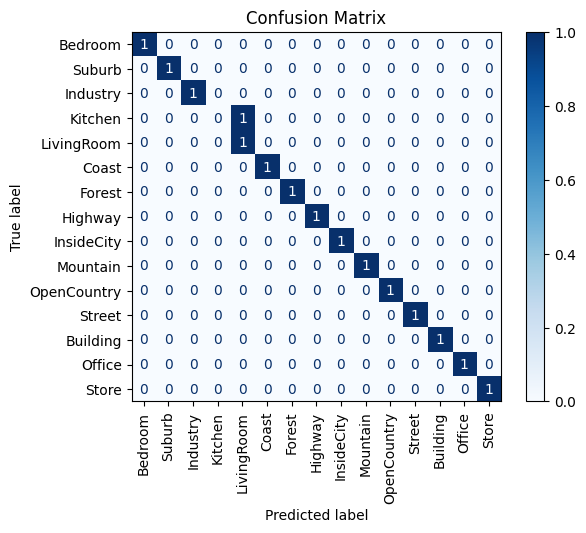

In [151]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_categories = []
predicted_categories = []

for true_category, test_features in all_test_features_by_category.items():
    print(f"True category: {true_category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)
    true_categories.append(true_category)
    predicted_categories.append(best_category)

labels = list(pca_by_category.keys())
cm = confusion_matrix(true_categories, predicted_categories, labels=labels)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()